In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from PIL import ImageFilter
from PIL import ImageEnhance

import os
import random
import string
from tqdm import tqdm


In [ ]:
label_path = "/content/gdrive/My Drive/Pallet_generator/Etiqueta.png"
box_path = "/content/gdrive/My Drive/Pallet_generator/Box.png"
background_path = "/content/gdrive/My Drive/Pallet_generator/background.jpg"
font_path = "/content/gdrive/My Drive/My Drive/Pallet_generator/ARIALNB.TTF"
etiqueta_noise_path = "/content/gdrive/My Drive/Pallet_generator/Etiqueta_noise.png"

box = Image.open("/content/gdrive/My Drive/Pallet_generator/Box.png")
#box.putalpha(255)
label = Image.open("/content/gdrive/My Drive/Pallet_generator/Etiqueta.png")
#label.putalpha(255)

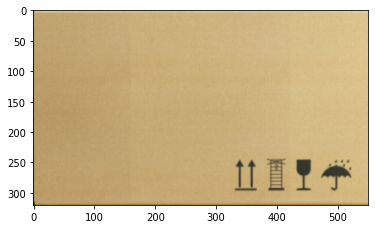

In [ ]:
plt.imshow(box)

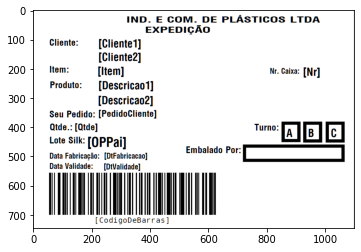

In [ ]:
plt.imshow(label)

In [ ]:
def insert_char(label_path,font_path):
    font = ImageFont.truetype(font_path, 130)
    letters = string.ascii_letters+string.digits
    charact = ''.join(random.choice(letters) for i in range(5))
    img = Image.open(label_path)
    draw = ImageDraw.Draw(img)
    draw.text(char_box,charact,(0,0,0),font=font)
    return img

In [ ]:
#a = insert_char(label_path,font_path)
#plt.imshow(a)

In [ ]:
def place_label(box,new_label):
    box_width, box_height = box.size
    l_width, l_height = new_label.size
    targ_width = box_width//5
    targ_height = l_height*(box_width//5)//l_width
    l_pos_x = random.randint(box_width*0.10, box_width*0.9-targ_width)
    l_pos_y = random.randint(box_height*0.10, box_height*0.9-targ_height)

    
    img = new_label.resize((targ_width,targ_height))   
    mask = Image.new('L', img.size, 255)
    
    rotate_angle = random.randint(-5,5)
    img = img.rotate(rotate_angle)
    mask = mask.rotate(rotate_angle)
    
    img1 = box.copy()
    img1.paste(img, box=(l_pos_x,l_pos_y), mask=mask)

    return img1, [l_pos_x, l_pos_y, l_pos_x+targ_width,l_pos_y+targ_height]

In [ ]:
#c,d = place_label(box,a)
#plt.imshow(c)
#print(d)

In [ ]:
#f = ImageDraw.Draw(c)   
#f.rectangle(d, outline ="red") 
#plt.imshow(c)

In [ ]:
def gen_bboxs(b_box,box_width,box_height,i,j):
    
    x0 = (b_box[0]+box_width*i)
    y0 = (b_box[1]+box_height*j)
    x1 = (b_box[2]+box_width*i)
    y1 = (b_box[3]+box_height*j)

    b_boxs = [x0,y0,x1,y1]
    return b_boxs

In [ ]:
def create_pallet(n_boxes_width,n_boxes_height,box,label_path,font_path):
    
    b_boxes = []
    box = Image.open(box_path)
    box_width, box_height = box.size
    box_stack_width = box_width*n_boxes_width
    box_stack_height = box_height*n_boxes_height

    box_stack = Image.new('RGBA', (box_stack_width, box_stack_height))

    for i in range(n_boxes_width):
        
        for j in range(n_boxes_height):
            
            im = insert_char(label_path,font_path)
            im,b_box = place_label(box,im)
            box_stack.paste(im, box=(0+box_width*i,0+box_height*j), mask=None)
            b_boxs = gen_bboxs(b_box,box_width,box_height,i,j)
            b_boxes.append(b_boxs)

    return box_stack, b_boxes

In [ ]:
#a,b = create_pallet(n_boxes_width,n_boxes_height,box,label_path,font_path)
#plt.imshow(a)

In [ ]:
#print(b)
#f = ImageDraw.Draw(a)   
#for i in range(4):
    	#f.rectangle(b[i], outline ="red")
#plt.imshow(a)

In [ ]:
def b_boxes_final(b_boxes, width_diff, height_diff):
    for i in b_boxes:
        i[0] = i[0]+width_diff
        i[1] = i[1]+height_diff
        i[2] = i[2]+width_diff
        i[3] = i[3]+height_diff
    return b_boxes

In [ ]:
def b_box_yolo(b_boxes, background_width, background_height):  
    
    box_yolo = []
    
    for i in b_boxes:  
        bb_width = i[2]-i[0]
        bb_height = i[3]-i[1]
        x_middle = i[0]+bb_width//2
        y_middle = i[1]+bb_height//2
        box_yolo.append([x_middle, y_middle,bb_width,bb_height])
    
    b_box_df = pd.DataFrame(box_yolo)
    b_box_df = b_box_df.astype(float) 
    b_box_df[0] = b_box_df[0]/background_width
    b_box_df[1] = b_box_df[1]/background_height
    b_box_df[2] = b_box_df[2]/background_width
    b_box_df[3] = b_box_df[3]/background_height
    b_box_df['class'] = '0'
    b_box_df = b_box_df[['class', 0, 1, 2, 3]]
    
    return b_box_df

In [ ]:
def gen_pall(count):
    count = count
    for k in tqdm(range(n_pall)):
        
        pallet, b_boxes = create_pallet(n_boxes_width,n_boxes_height,box,label_path,font_path)
        
        pallet_width, pallet_height = pallet.size
        f_image_width = pallet_width*1.2
        f_image_height = pallet_height*1.1

        background = Image.open(background_path)
        background = background.resize((int(f_image_width),int(f_image_height)))

        background_width, background_height = background.size

        pallet_picture = background.filter(ImageFilter.BLUR)
        pallet_picture.paste(pallet, box=(int(pallet_width*0.1),int(pallet_height*0.1)))
        
        etiqueta_noise = Image.open(etiqueta_noise_path)
        etiqueta_noise = etiqueta_noise.resize((int(box.size[0]/3),int(etiqueta_noise.size[1]*(box.size[0]/3)/etiqueta_noise.size[0])))
        pallet_picture.paste(etiqueta_noise, box=(int((background_width+random.randint(-50,50))/2),int((background_height+random.randint(-50,50))/2)))
        
        enhancer = ImageEnhance.Brightness(pallet_picture)
        pallet_picture = enhancer.enhance(random.uniform(0.5, 1))

        plt.imshow(pallet_picture)
        
        pallet_picture.save(f"/content/gdrive/My Drive/Pallet_generator/Pallets/obj/pic{count}.png")
        #print(pallet_picture.size)
        b_boxes = b_boxes_final(b_boxes, pallet_width*0.1, pallet_height*0.1)
        #print(b_boxes)
        #f = ImageDraw.Draw(pallet_picture)   
        #for i in range(4):
            #f.rectangle(b_boxes[i], outline ="red")
        #plt.imshow(pallet_picture)
        
        b_box_df = b_box_yolo(b_boxes,background_width, background_height)
        #print(b_box_df.head(5))
        np.savetxt(f"/content/gdrive/My Drive/Pallet_generator/Pallets/obj/pic{count}.txt", b_box_df.values, fmt=['%s','%f','%f','%f','%f'])
        count += 1

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


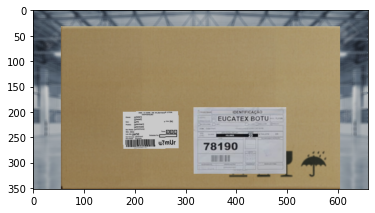

In [ ]:
char_box = (700, 550)
n_boxes_width = 1
n_boxes_height = 1
n_pall =10
count = 1
gen_pall(count)

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


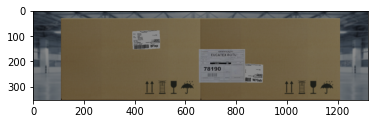

In [ ]:
char_box = (700, 550)
n_boxes_width = 2
n_boxes_height = 1
n_pall =10
count = 11
gen_pall(count)

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


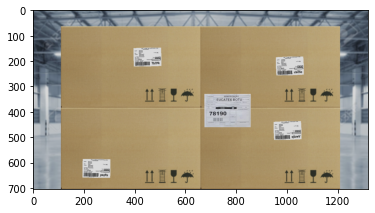

In [ ]:
char_box = (700, 550)
n_boxes_width = 2
n_boxes_height = 2
n_pall =10
count = 21
gen_pall(count)

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


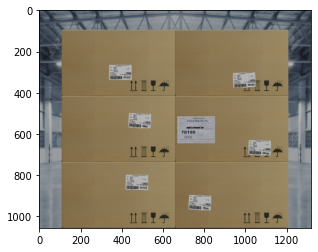

In [ ]:
char_box = (700, 550)
n_boxes_width = 2
n_boxes_height = 3
n_pall =10
count = 31
gen_pall(count)

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


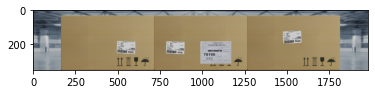

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 1
n_pall =10
count = 41
gen_pall(count)

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


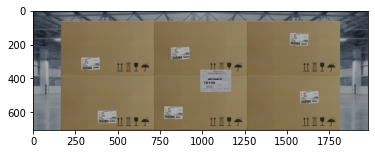

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 2
n_pall =10
count = 51
gen_pall(count)

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


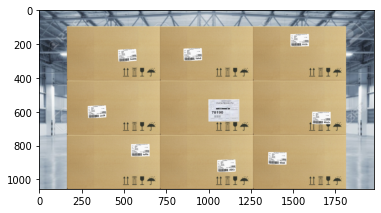

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 3
n_pall =10
count = 61
gen_pall(count)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


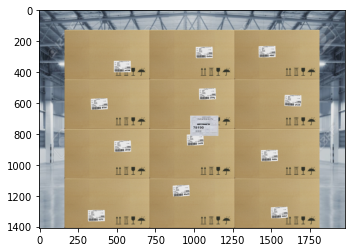

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 4
n_pall =10
count = 71
gen_pall(count)

100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


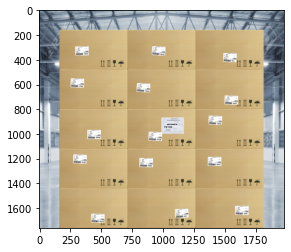

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 5
n_pall =10
count = 81
gen_pall(count)

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


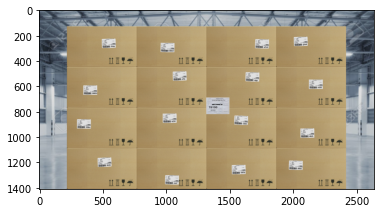

In [ ]:
char_box = (700, 550)
n_boxes_width = 4
n_boxes_height = 4
n_pall =10
count = 91
gen_pall(count)

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


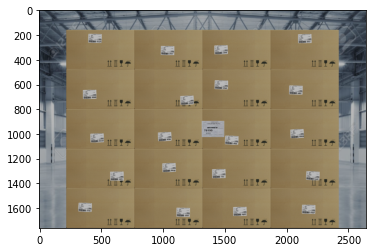

In [ ]:
char_box = (700, 550)
n_boxes_width = 4
n_boxes_height = 5
n_pall =10
count = 101
gen_pall(count)

100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


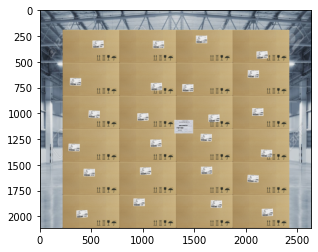

In [ ]:
char_box = (700, 550)
n_boxes_width = 4
n_boxes_height = 6
n_pall =10
count = 121
gen_pall(count)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


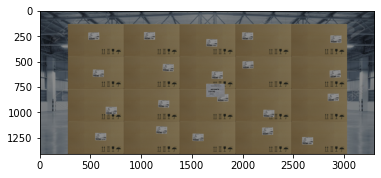

In [ ]:
char_box = (700, 550)
n_boxes_width = 5
n_boxes_height = 4
n_pall =10
count = 121
gen_pall(count)

In [ ]:
char_box = (700, 550)
n_boxes_width = 3
n_boxes_height = 4
n_pall =10
count = 71
gen_pall(count)

In [ ]:
'''
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=numpy.float)
    B = numpy.array(pb).reshape(8)

    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)
'''

'\ndef find_coeffs(pa, pb):\n    matrix = []\n    for p1, p2 in zip(pa, pb):\n        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])\n        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])\n\n    A = numpy.matrix(matrix, dtype=numpy.float)\n    B = numpy.array(pb).reshape(8)\n\n    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)\n    return numpy.array(res).reshape(8)\n'

In [ ]:
'''
width, height = im1.size
coeffs = find_coeffs(
        [(0, 0), (width, 0), (width, height), (0, height)],
        [(0, 0), (width, 50), (width, height-50), (0, height)])

pallet_picture = im1.transform((width, height), Image.PERSPECTIVE, coeffs,Image.BICUBIC)

plt.imshow(pallet_picture)
pallet_picture.save("/content/gdrive/My Drive/Pallet_generator/pic.png")
'''

'\nwidth, height = im1.size\ncoeffs = find_coeffs(\n        [(0, 0), (width, 0), (width, height), (0, height)],\n        [(0, 0), (width, 50), (width, height-50), (0, height)])\n\npallet_picture = im1.transform((width, height), Image.PERSPECTIVE, coeffs,Image.BICUBIC)\n\nplt.imshow(pallet_picture)\npallet_picture.save("/content/gdrive/My Drive/Pallet_generator/pic.png")\n'